# Algorithms and Big Data in Chemistry and Materials
## Hometask 1

Each team has its own set of data (1.csv - 14.csv) collected using natural language processing algorithms.
Your task:
1. Choose any three databases or APIs from the lecture examples. Extract at least 1000 descriptors. All three selected database or APIs should be used.
2. Perform each data cleansing steam (validation, handling of missing values, detection of outliers, handling of duplicates, data transformation and normalization). Some steps are best done before descriptors are extracted.

Complete all the steps of the assignment in a Jupiter Notebook (one per team). Upload the finalized Jupiter Notebook to the Google Drive of the course. Remember that the next two homework assignments can only be started after the first one has been completed. The deadline for completing all three homework assignments is 23:59 of 25.03. 



## 1. Installing libraries and uploading data

In [21]:
%pip install rdkit
%pip install mordred
%pip install scipy
%pip install statannot
%pip install pandas
%pip install numpy
%pip install pubchempy
%pip install rdkit
%pip install chemspipy
%pip install chembl_webresource_client
%pip install cirpy
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [22]:
import pandas as pd

In [23]:
#Installing the necessary libraries
import pandas as pd
import numpy as np
import requests as re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import re
import pubchempy as pcp
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import Descriptors3D
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdchem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.rdchem import PeriodicTable, GetPeriodicTable
from rdkit.Chem import Fragments
from rdkit.Chem.rdchem import EditableMol
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
from rdkit.Chem import PyMol
import scipy
import statannot
from urllib.request import urlopen
from urllib.parse import quote
import requests
from mordred import Calculator, descriptors
from bs4 import BeautifulSoup
from chembl_webresource_client.new_client import new_client
import chemspipy
import subprocess
import cirpy
import random
from scipy import  stats, special
from collections import Counter
colors = ['#a5678e','#e8b7d4', '#beb7d9', '#7eabd4', '#31539d'] # Palette of colors
plt.style.use('seaborn')

C:\Users\iyale\AppData\Local\Temp\ipykernel_16828\2186836767.py:42: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



In [9]:
#Reading a dataset
Refr_ind_df = pd.read_csv("10.csv")
Refr_ind_df.head(3)

,DOI,Date,Journal,Title,Name,measurement_error,measurement_wavelength,measurement_method,normalised_name,raw_value,specifier
0,10.1016/j.materresbull.2017.08.038,8/25/2017,Materials Research Bulletin,CDCL2TREATMENTCONCENTRATIONEVOLUTIONPHYSICALPR...,CdCl2,0.0,NaN,el_cde_tables,NaN,2.49,refractive index
1,10.1016/S0021-9797(03)00199-1,4/26/2003,Journal of Colloid and Interface Science,EVALUATIONDLVOTHEORYDISJOININGPRESSUREFILMCOND...,Dodecanol,0.0,NaN,el_mylogic,NaN,1.411,n (index of refraction)
2,10.1016/S0030-4018(00)01152-4,2/9/2001,Optics Communications,DISPERSIONOPTICALCONSTANTSQUARTZPOLYMETHYLMETH...,PMMA,0.0,3000 nm,el_mylogic,NaN,1.552,n


## 2. Working with errors in the dataset, missing values, etc.

### 2.1. Dataset Information

In [10]:
#Dataset Information
Refr_ind_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DOI                     5000 non-null   object 
 1   Date                    4588 non-null   object 
 2   Journal                 4588 non-null   object 
 3   Title                   4588 non-null   object 
 4   Name                    4995 non-null   object 
 5   measurement_error       5000 non-null   float64
 6   measurement_wavelength  622 non-null    object 
 7   measurement_method      5000 non-null   object 
 8   normalised_name         2996 non-null   object 
 9   raw_value               5000 non-null   object 
 10  specifier               5000 non-null   object 
dtypes: float64(1), object(10)
memory usage: 429.8+ KB


**Conclusions:**
1. A large number of missing values, so you need to supplement SMILES, and if possible, the remaining values
2. Some numerical signs are indicated in a strange way
3. Dataset is a set of refractive indexes for various substances (organic + inorganic)
4. There are problems with recording inorganic in the form of smiles
5. The column with the refractive index and doi values also needs to be cleaned

### 2.2. Filling in missing names
The dataset lacks several values in the Name column, but there are SMILES for them, so we will add these values using CACTUS

In [11]:
CACTUS = "https://cactus.nci.nih.gov/chemical/structure/{0}/{1}" #link to the library
# Function for converting smiles to iupac name
def smiles_to_iupac(smiles):
   
    rep = "iupac_name" #Required parameter
    url = CACTUS.format(smiles, rep) #Getting a link
    #Getting a name and converting it to text
    response = requests.get(url) 
    response.raise_for_status()
    return response.text

#Application of the function
for ind in Refr_ind_df[Refr_ind_df['Name'].isna()].index:
    Refr_ind_df.loc[ind, 'Name'] = smiles_to_iupac(Refr_ind_df.loc[ind, 'normalised_name'])

### 2.3. Separation of DOI and journal name
There are two types of wrong doi:
1. 10.1039/C1EE01297E_Â© The Royal Society of Chemistry 2011
2. 10.1016/S0002-9394(02)01517-9American Journal of Ophthalmology

In the first case, you need to remove everything after the '_' symbol, in the second with a capital letter of the journal name


In [13]:
#Функция для выделения doi
def correction_doi(old_doi):
    # Looking for a symbol '_'
    if old_doi.find('_') != -1:
        new_doi = old_doi[0 : old_doi.find('_')] #Cutting a string by a symbol
    # We find a combination of lowercase and uppercase letters, since this can only be in the name of the magazine
    elif len(re.findall(r'([A-Z][a-z])', old_doi)) != 0:
        new_doi = old_doi[0 : old_doi.find(re.findall(r'([A-Z][a-z])', old_doi)[0])] #Cutting a string by a symbol
    # If there are no problems, we leave the old one
    else:
        new_doi = old_doi
    return new_doi

#Application of the function
Refr_ind_df['DOI'] = Refr_ind_df['DOI'].apply(correction_doi)

### 2.4. Converting raw_value to normal form
To bring raw_value to its normal form, it is necessary to remove unnecessary characters such as '-', '∼' and '+/-'

In [14]:
#Function for converting raw_value to normal form
def correction_raw_value(old_raw_value):
    try:
        old_raw_value = str(old_raw_value) #Converting to str
        #Search for values starting with the '∼' character and crop by this character
        if old_raw_value[0] == '∼':
            new_raw_value = old_raw_value[1:]
            return float(new_raw_value) #Returning a float type value
        # If there are characters in the string other than numbers and dots, cut them off
        elif len(re.findall(r'[^0-9.]', old_raw_value)) != 0:
            new_raw_value = old_raw_value[0 : old_raw_value.find(re.findall(r'[^0-9.]', old_raw_value)[0])]
            #If there are several points, cut off after the second point
            if new_raw_value.find('.', new_raw_value.find('.')+1) != -1:
                new_raw_value = new_raw_value[0:new_raw_value.find('.', new_raw_value.find('.')+1)]
            return float(new_raw_value) #Returning a float type value    
        else:
            #If there are several points, cut off after the second point
            if old_raw_value.find('.', old_raw_value.find('.')+1) != -1:
                old_raw_value = old_raw_value[0:old_raw_value.find('.', old_raw_value.find('.')+1)]
            return float(old_raw_value) #Returning a float type value
    except:
        return None

#Application of the function    
Refr_ind_df['Refractive_index'] = Refr_ind_df['raw_value'].apply(correction_raw_value)

### 2.5. Sorting and deleting repetitions
For further work with the data, it is necessary to clear the dataset of outliers and remove repetitions

Shape of dataset (4751, 12)


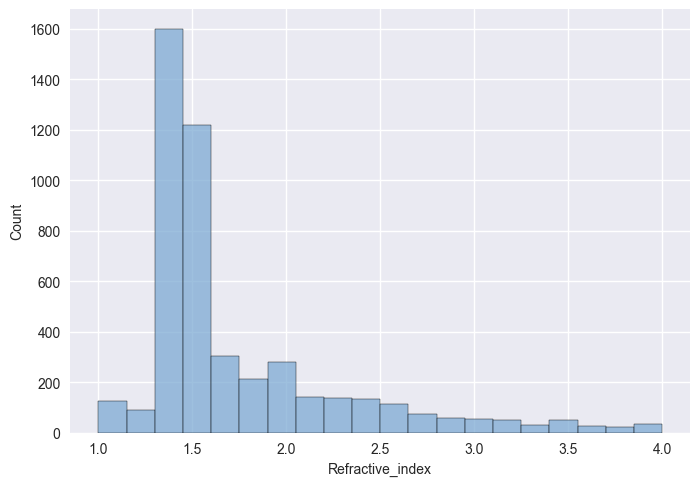

In [15]:
#Removing duplicates
Refr_ind_df = Refr_ind_df.drop_duplicates()
#The Refractive index varies in the range from 1.0 to 4.0. Therefore, we will delete all values that do not fit the physical meaning
Refr_ind_df = Refr_ind_df[(Refr_ind_df['Refractive_index'] >= 1.0) & (Refr_ind_df['Refractive_index'] <= 4.0)]
print('Shape of dataset', Refr_ind_df.shape) #Shape of dataset
#The histogram of the Refractive index distribution
sns.histplot(x=Refr_ind_df['Refractive_index'], color=colors[3], bins = 20)
plt.show()

In [16]:
# The main characteristics of the dataset
mean = Refr_ind_df['Refractive_index'].mean()
std = Refr_ind_df['Refractive_index'].std()
median = np.median(Refr_ind_df['Refractive_index'])
mode = stats.mode(Refr_ind_df['Refractive_index'], keepdims=False).mode
quartiles = np.quantile(Refr_ind_df['Refractive_index'], [0.25, 0.5, 0.75])
irq = stats.iqr(Refr_ind_df['Refractive_index'])
print("Mean:", mean)
print("STD:", std)
print("Median:", median)
print("Mode:", mode)
print("Quartiles:", quartiles)
print("IRQ:", irq)

Mean: 1.7318373507209008
STD: 0.5588948950931371
Median: 1.494
Mode: 1.5
Quartiles: [1.3994 1.494  1.9   ]
IRQ: 0.5005999999999999


In [17]:
#Boxplot for dataset
fig_data = [go.Box(y = Refr_ind_df['Refractive_index'],
                   q1=[quartiles[0]], 
                   median=[quartiles[1]],
                   q3=[quartiles[2]], 
                   lowerfence=[Refr_ind_df['Refractive_index'].min()],
                   upperfence=[Refr_ind_df['Refractive_index'].max()], 
                   mean=[mean],
                   sd=[std],
                  marker_color=colors[3])
           ]
layout = go.Layout(xaxis={"dtick": 1})
fig = go.Figure(data=fig_data,
                layout=layout)
fig.show()

**Conclusions:**
1. The median and the mean are very different
2. The distribution is not normal, as it contains various amounts of organic and inorganic substances
3. A large number of emissions
4. At the moment, we have deleted data that does not fall within the range of the Refractive index physical values, the remaining values for outliers have been reviewed, due to the disparity of the dataset, we decided not to delete them, as we may lose interesting values that may be important for further clustering/prediction, in addition, some of the values get out because of the inability to find smiles

In [18]:
# Let's create a table containing individual substances, as well as average values and deviations for them
new_df = Refr_ind_df[['Name', 'Refractive_index']].groupby('Name').agg(['count', 'mean', 'std'])
new_df.columns = ['_'.join(col).rstrip('_') for col in new_df.columns.values] #Names for new columns
new_df = new_df.sort_values('Refractive_index_count', ascending = False) #Sort in descending order
new_df

,Refractive_index_count,Refractive_index_mean,Refractive_index_std
Name,,,
TiO2,108,2.246248,0.401396
SiO2,101,1.539053,0.363925
silica,97,1.431448,0.155530
ZnO,61,2.015932,0.410117
PMMA,57,1.492072,0.114672
...,...,...,...
H(HfO2),1,1.950000,NaN
Guanidine,1,1.595000,NaN
Grilon,1,1.400000,NaN


## 3. SMILES
Далее для удобства добавления смайлс и дескрипторов будем работать с таблицей, в которой только индивидуальные компоненты

In [19]:
ind_df = new_df.reset_index()
ind_df = pd.DataFrame(ind_df['Name'])
ind_df

,Name
0,TiO2
1,SiO2
2,silica
3,ZnO
4,PMMA
...,...
1804,H(HfO2)
1805,Guanidine
1806,Grilon
1807,Gold


In [20]:
#To get more universal names, turn to wikipedia
def Get_Name_from_wiki(old_name):
    response = requests.get(url="https://en.wikipedia.org/wiki/" + old_name) #Link Search
    #Parse the page title
    soup = BeautifulSoup(response.content, 'html.parser') 
    title = soup.find(id = 'firstHeading')
    new_name = title.string
    #If it was not found, then we leave the old name
    if new_name is not None:
        return new_name
    else:
        return old_name

#Application of the function
ind_df['Wiki_name'] = ind_df['Name'].apply(Get_Name_from_wiki)
ind_df

KeyboardInterrupt: 

In [52]:
#Functions for parsing SMILES from various resources
def CACTUS_SMILES(name):
    try:
        url = 'http://cactus.nci.nih.gov/chemical/structure/' + quote(name) + '/smiles'
        smiles = urlopen(url).read().decode('utf8')
        return smiles
    except:
        return None


def PubChemSMILES(name):
    try:
        smiles = pcp.get_properties('CanonicalSMILES', name, 'name')[0]['CanonicalSMILES']
    except:
        try:
            smiles = pcp.get_properties('CanonicalSMILES', name, 'formula')[0]['CanonicalSMILES']
        except:
            smiles = None
    return smiles


def ChemblSMILES(name):
    try:
        mol = new_client.molecule
        compound = mol.search(name)[0]
        smiles = compound['molecule_structures']['canonical_smiles']
        return smiles
    except:
        return None


# For composites, you can write a function that breaks them into parts and searches for SMILES in parts
def f_get_smiles_NP(name):
    try:
        comp_list = re.split(r"–", name) #Division by the "-" symbol
        res_smi = ''
        for comp in comp_list:
            smi = CACTUS_SMILES(comp) #Finding SMILES for individual components
            res_smi = res_smi + smi + '.' #Adding SMILES through a dot
        res_smi = res_smi[:-1] #Removing the last dot
        return res_smi
    except:
        return None

In [53]:
#To get all the SMILES, let's try to use all the services and choose the most popular answer
def f_get_canon_smiles(name):
    print(name)
    #Checking for composite
    if name.find('–') != -1:
        return f_get_smiles_NP(name)
    
    else:
        try:
            smiles = CACTUS_SMILES(name)
        except:
            try:
                smiles = PubChemSMILES(name)
            except:
                try:
                    smiles = ChemblSMILES(name)
                except:
                    return None
                
    return smiles

          

In [54]:
f_get_canon_smiles('1-Hexyl-3-methylimidazolium')

1-Hexyl-3-methylimidazolium


'CCCCCC[n+]1ccn(C)c1'

In [55]:
##Adding data to the main table
ind_df['SMILES'] = ind_df['Name'].apply(f_get_canon_smiles)
ind_df

TiO2
SiO2
silica
ZnO
PMMA
silicon
ethanol
Methanol
Ethanol
nitrobenzene
Toluene
Acetonitrile
quartz
Al2O3
DMSO
Acetone
Chloroform
1-Propanol
ZnS
H2O
NaCl
CO2
EtOH
TEG
Benzene
ZrO2
1-Butanol
ITO
methanol
GaN
Cyclohexane
DMF
HfO2
PDMS
2-Propanol
THF
NaBr
ZnSe
polystyrene
MeCN
toluene
BK7
benzene
oxygen
calcite
alcohols
isopropylacetate
GaAs
Silica
n-Butanol
Si3N4
glycerol
MgF2
AlN
2-propanol
tetralin
SiC
Polystyrene
glycine
carbon
tellurite
CeO2
AZO
CHCl3
Hexane
Silicon
alcohol
silver
FeSO4
CH2Cl2
Glycerol
ChCL
n-Hexane
(±)-linalool
SiN
ZnTe
WO3
sugar
Dichloromethane
CdS
1-Butyl-3-methylimidazolium tetrafluoroborate
Ethylacetate
Ethyl acetate
Dioxane
phosphate
phenol
Diethylether
CdTe
MgO
glucose
chitin
Butyl acetate
Isopropanol
tetrahydrofuran
aniline
Urea
Pentanol
Tetrahydrofuran
Y2O3
NaPh4B
chloroform
titania
DMC
silicon dioxide
CsCl
Glucose
SnO2
PVA
acetone
tert-butyl benzene
sapphire
PVC
n-decane
PTFE
GeO2
NaF
cholesterol
KRI
lactose
Aniline
distilled water
CaF2
p-Xylene
NMP
LiNbO3


,Name,Wiki_name,SMILES
0,TiO2,Titanium dioxide,O=[Ti]=O
1,SiO2,Silicon dioxide,None
2,silica,Silicon dioxide,O=[Si]=O
3,ZnO,Zinc oxide,O|[Zn++]|O
4,PMMA,PMMA,COC(=O)[C](C)C
...,...,...,...
1804,H(HfO2),H(HfO2),None
1805,Guanidine,Guanidine,NC(N)=N
1806,Grilon,Grilon,CCCCCC(N)=O
1807,Gold,Gold,[Au]


In [56]:
#Saving to a file for a little editing
ind_df.to_excel('ind_df_withsmiles.xlsx')

In [57]:
ind_df = ind_df.dropna(subset = ['SMILES'])
ind_df

,Name,Wiki_name,SMILES
0,TiO2,Titanium dioxide,O=[Ti]=O
2,silica,Silicon dioxide,O=[Si]=O
3,ZnO,Zinc oxide,O|[Zn++]|O
4,PMMA,PMMA,COC(=O)[C](C)C
5,silicon,Silicon,[SiH4]
...,...,...,...
1803,H2O2,Hydrogen peroxide,OO
1805,Guanidine,Guanidine,NC(N)=N
1806,Grilon,Grilon,CCCCCC(N)=O
1807,Gold,Gold,[Au]


In [39]:
ind_df = pd.read_excel('ind_df_withsmiles.xlsx')
ind_df

,Unnamed: 0,Name,Wiki_name,SMILES
0,0,TiO2,Titanium dioxide,O=[Ti]=O
1,1,SiO2,Silicon dioxide,NaN
2,2,silica,Silicon dioxide,O=[Si]=O
3,3,ZnO,Zinc oxide,O|[Zn++]|O
4,4,PMMA,PMMA,COC(=O)[C](C)C
...,...,...,...,...
1804,1804,H(HfO2),H(HfO2),NaN
1805,1805,Guanidine,Guanidine,NC(N)=N
1806,1806,Grilon,Grilon,CCCCCC(N)=O
1807,1807,Gold,Gold,[Au]


## 4. RDKit
### 4.1. Молекулярные дескрипторы

In [41]:
# Function for adding molecular descriptors
def RDKit_descriptors(smiles):   
    mol = Chem.MolFromSmiles(smiles) #Getting a molecule
    calc = MoleculeDescriptors.MolecularDescriptorCalculator(x[0] for x in Descriptors._descList) 
    desc_names = calc.GetDescriptorNames() #Getting descriptor names
    Mol_descriptors = [] #List to fill with descriptor values
    try:
        mol = Chem.AddHs(mol) #Molecule with H
        descriptors = calc.CalcDescriptors(mol) #Calculation of descriptors
        Mol_descriptors.append(descriptors) #Adding descriptors to a sheet
    except:
        descriptors = [None for _ in range(208)]
        Mol_descriptors.append(descriptors)
    return list(Mol_descriptors[0])

#Adding data to the main table
calc = MoleculeDescriptors.MolecularDescriptorCalculator(x[0] for x in Descriptors._descList) 
desc_names = list(calc.GetDescriptorNames())

ind_df[desc_names] = None
for ind in ind_df.index:
    try:  
        ind_df.loc[ind, desc_names] = RDKit_descriptors(ind_df.loc[ind, 'SMILES'])
    except:
        pass

ind_df = ind_df.drop(ind_df.columns[[-1]], axis = 1)


C:\Users\iyale\AppData\Local\Temp\ipykernel_16828\913249040.py:20: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\iyale\AppData\Local\Temp\ipykernel_16828\913249040.py:20: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\iyale\AppData\Local\Temp\ipykernel_16828\913249040.py:20: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

### 4.2. 3D Descriptors

In [42]:
def f_get_3D_Descriptors(smiles):
    try:
        mol = Chem.AddHs(Chem.MolFromSmiles(smiles)) #Getting the molecule
        #Optimization of the geometry of the molecule
        ps = AllChem.EmbedParameters() 
        ps.embedFragmentsSeparately = False
        ps.useRandomCoords = True
        ps.useExpTorsionAnglePrefs=True
        ps.useBasicKnowledge=True
        ps.randomSeed = 98
        flag = AllChem.EmbedMultipleConfs(mol, 10, ps)
        AllChem.MMFFOptimizeMoleculeConfs(mol)
        #Descriptor list
        res_desc = [Descriptors3D.Asphericity(mol), Descriptors3D.Eccentricity(mol), Descriptors3D.InertialShapeFactor(mol), Descriptors3D.NPR1(mol), Descriptors3D.NPR2(mol), Descriptors3D.PMI1(mol), Descriptors3D.PMI2(mol), Descriptors3D.PMI3(mol), Descriptors3D.RadiusOfGyration(mol), Descriptors3D.SpherocityIndex(mol)] #Вычисление дескриптора
        return res_desc
    except:
        return [None for _ in range(10)]

    

#Adding data to the main table
desc_names = ['Asphericity', 'Eccentricity', 'InertialShapeFactor', 'NPR1', 'NPR2', 'PMI1', 'PMI2', 'PMI3', 'RadiusOfGyration', 'SpherocityIndex']
ind_df[desc_names] = None
for ind in ind_df.index:
    try:  
        ind_df.loc[ind, desc_names] = f_get_3D_Descriptors(ind_df.loc[ind, 'SMILES'])
    except:
        pass



C:\Users\iyale\AppData\Local\Temp\ipykernel_16828\495518352.py:23: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\iyale\AppData\Local\Temp\ipykernel_16828\495518352.py:23: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\iyale\AppData\Local\Temp\ipykernel_16828\495518352.py:23: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

## 5. PubChem

In [43]:
def Get_PubChem_Descriptors(smiles):
    results = pcp.get_compounds(smiles, 'smiles')
    compound = results[0].cid
    PubChemdesc_list = ['MolecularFormula', 'MolecularWeight', 'IsomericSMILES', 'InChI', 'InChIKey', 'IUPACName', 'XLogP', 'ExactMass', 'MonoisotopicMass', 'TPSA', 'Complexity', 'Charge', 'HBondDonorCount', 'HBondAcceptorCount', 'RotatableBondCount', 'HeavyAtomCount', 'IsotopeAtomCount', 'AtomStereoCount', 'DefinedAtomStereoCount', 'UndefinedAtomStereoCount', 'BondStereoCount', 'DefinedBondStereoCount', 'UndefinedBondStereoCount', 'CovalentUnitCount', 'Volume3D', 'XStericQuadrupole3D', 'YStericQuadrupole3D', 'ZStericQuadrupole3D', 'FeatureCount3D', 'FeatureAcceptorCount3D', 'FeatureDonorCount3D', 'FeatureAnionCount3D', 'FeatureCationCount3D', 'FeatureRingCount3D', 'FeatureHydrophobeCount3D', 'ConformerModelRMSD3D', 'EffectiveRotorCount3D', 'ConformerCount3D']
    descriptors = pcp.get_properties(PubChemdesc_list, compound, 'cid')
    return list(descriptors[0].values())

#Adding data to the main table
PubChemdesc_list = ['CID','MolecularFormula', 'MolecularWeight', 'IsomericSMILES', 'InChI', 'InChIKey', 'IUPACName', 'XLogP', 'ExactMass', 'MonoisotopicMass', 'TPSA', 'Complexity', 'Charge', 'HBondDonorCount', 'HBondAcceptorCount', 'RotatableBondCount', 'HeavyAtomCount', 'IsotopeAtomCount', 'AtomStereoCount', 'DefinedAtomStereoCount', 'UndefinedAtomStereoCount', 'BondStereoCount', 'DefinedBondStereoCount', 'UndefinedBondStereoCount', 'CovalentUnitCount', 'Volume3D', 'XStericQuadrupole3D', 'YStericQuadrupole3D', 'ZStericQuadrupole3D', 'FeatureCount3D', 'FeatureAcceptorCount3D', 'FeatureDonorCount3D', 'FeatureAnionCount3D', 'FeatureCationCount3D', 'FeatureRingCount3D', 'FeatureHydrophobeCount3D', 'ConformerModelRMSD3D', 'EffectiveRotorCount3D', 'ConformerCount3D']
ind_df[PubChemdesc_list] = None
for ind in ind_df.index:
    try:    
        ind_df.loc[ind, PubChemdesc_list] = Get_PubChem_Descriptors(ind_df.loc[ind, 'SMILES'])
    except:
        pass

C:\Users\iyale\AppData\Local\Temp\ipykernel_16828\18047146.py:10: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\iyale\AppData\Local\Temp\ipykernel_16828\18047146.py:10: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\iyale\AppData\Local\Temp\ipykernel_16828\18047146.py:10: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fra

In [46]:
ind_df.to_excel('ind_df_rdkit_pubchem.xlsx')

In [70]:
ind_df = ind_df.dropna(subset='SMILES')

## 6. Mordred

In [71]:

#We converse all emoticons into molecules and delete those. which didn 't work out
ind_df['mol'] = ind_df['SMILES'].apply(Chem.MolFromSmiles)
ind_df = ind_df.dropna(subset = ['mol'])
ind_df

def All_Mordred_descriptors(mols):
    calc = Calculator(descriptors, ignore_3D = False)
    #mols = [Chem.MolFromSmiles(smi) for smi in data]
    df = calc.pandas(mols)
    return df


mordred_descriptors = All_Mordred_descriptors(ind_df['mol'])
ind_df = pd.concat((ind_df, mordred_descriptors), axis = 1)

[19:55:17] SMILES Parse Error: syntax error while parsing: O|[Zn++]|O
[19:55:17] SMILES Parse Error: Failed parsing SMILES 'O|[Zn++]|O' for input: 'O|[Zn++]|O'
[19:55:17] Explicit valence for atom # 0 O, 3, is greater than permitted
[19:55:17] SMILES Parse Error: syntax error while parsing: [OH-]|[Mg++](|[OH-])(|[OH-])(|[OH-])(|[OH-])|[OH-]
[19:55:17] SMILES Parse Error: Failed parsing SMILES '[OH-]|[Mg++](|[OH-])(|[OH-])(|[OH-])(|[OH-])|[OH-]' for input: '[OH-]|[Mg++](|[OH-])(|[OH-])(|[OH-])(|[OH-])|[OH-]'
[19:55:17] WARNING: not removing hydrogen atom without neighbors
[19:55:17] Explicit valence for atom # 0 O, 4, is greater than permitted
[19:55:17] WARNING: not removing hydrogen atom without neighbors
[19:55:17] WARNING: not removing hydrogen atom without neighbors
[19:55:17] SMILES Parse Error: syntax error while parsing: O=[Te]=O.O=BOB=O.O|[Zn++]|O
[19:55:17] SMILES Parse Error: Failed parsing SMILES 'O=[Te]=O.O=BOB=O.O|[Zn++]|O' for input: 'O=[Te]=O.O=BOB=O.O|[Zn++]|O'
[19:55:1

c:\Users\iyale\anaconda3\envs\myenv\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[19:55:23] WARNING: not removing hydrogen atom without neighbors
[19:55:23] WARNING: not removing hydrogen atom without neighbors
[19:55:23] WARNING: not removing hydrogen atom without neighbors
[19:55:25] WARNING: not removing hydrogen atom without neighbors
[19:55:25] WARNING: not removing hydrogen atom without neighbors
[19:55:25] WARNING: not removing hydrogen atom without neighbors
[19:55:25] WARNING: not removing hydrogen atom without neighbors
[19:55:25] WARNING: not removing hydrogen atom without neighbors
[19:55:25] WARNING: not removing hydrogen atom without neighbors
[19:55:27] WARNING: not removing hydrogen atom without neighbors
[19:55:27] WARNING: not removing hydrogen atom without neighbors
[19:55:27] WARNING: not removing hydrogen atom without neighbors


c:\Users\iyale\anaconda3\envs\myenv\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\iyale\anaconda3\envs\myenv\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\iyale\anaconda3\envs\myenv\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\iyale\anaconda3\envs\myenv\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[19:55:40] WARNING: not removing hydrogen atom without neighbors
[19:55:40] WARNING: not removing hydrogen atom without neighbors
[19:55:40] WARNING: not removing hydrogen atom without neighbors


c:\Users\iyale\anaconda3\envs\myenv\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[19:55:42] WARNING: not removing hydrogen atom without neighbors
[19:55:42] WARNING: not removing hydrogen atom without neighbors
[19:55:42] WARNING: not removing hydrogen atom without neighbors


c:\Users\iyale\anaconda3\envs\myenv\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[19:55:43] WARNING: not removing hydrogen atom without neighbors
[19:55:43] WARNING: not removing hydrogen atom without neighbors
[19:55:43] WARNING: not removing hydrogen atom without neighbors


c:\Users\iyale\anaconda3\envs\myenv\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[19:55:47] WARNING: not removing hydrogen atom without neighbors
[19:55:47] WARNING: not removing hydrogen atom without neighbors
[19:55:47] WARNING: not removing hydrogen atom without neighbors
[19:55:47] WARNING: not removing hydrogen atom without neighbors
[19:55:47] WARNING: not removing hydrogen atom without neighbors
[19:55:47] WARNING: not removing hydrogen atom without neighbors
[19:55:47] WARNING: not removing hydrogen atom without neighbors
[19:55:47] WARNING: not removing hydrogen atom without neighbors
[19:55:47] WARNING: not removing hydrogen atom without neighbors


In [72]:
ind_df

,Unnamed: 0,Name,Wiki_name,SMILES,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,0,TiO2,Titanium dioxide,O=[Ti]=O,8.5,-2.0,8.5,2.0,0.376008,79.865,...,4.174387,17.310771,79.937776,26.645925,4,0,6.0,4.0,2.25,1.000000
2,2,silica,Silicon dioxide,O=[Si]=O,8.402778,-1.416667,8.402778,1.416667,0.349091,60.084,...,4.174387,17.310771,59.966756,19.988919,4,0,6.0,4.0,2.25,1.000000
4,4,PMMA,PMMA,COC(=O)[C](C)C,11.11294,-3.228588,11.11294,1.517477,0.455942,101.125,...,7.890957,32.688753,101.060255,6.316266,46,6,26.0,26.0,4.472222,1.777778
5,5,silicon,Silicon,[SiH4],6.076389,-3.611111,6.076389,3.611111,0.286518,32.118,...,0.000000,1.000000,32.008227,6.401645,0,0,0.0,0.0,divide by zero encountered in power (mZagreb1),0.000000
6,6,ethanol,Ethanol,CCO,6.520833,-2.880208,6.520833,2.854167,0.406808,46.069,...,4.174387,17.310771,46.041865,5.115763,4,0,6.0,4.0,2.25,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1803,1803,H2O2,Hydrogen peroxide,OO,5.541667,2.958333,5.541667,2.958333,0.292487,34.014,...,1.098612,7.493061,34.005479,8.501370,1,0,2.0,1.0,2.0,1.000000
1805,1805,Guanidine,Guanidine,NC(N)=N,6.43287,-0.685185,6.43287,0.090278,0.242956,59.072,...,6.188264,24.179697,59.048347,6.560927,9,0,12.0,9.0,3.111111,1.000000
1806,1806,Grilon,Grilon,CCCCCC(N)=O,11.340716,-3.962963,11.340716,0.820615,0.54665,115.176,...,7.475906,33.090360,115.099714,5.480939,79,5,28.0,26.0,4.111111,2.083333
1807,1807,Gold,Gold,[Au],0.0,0.0,0.0,0.0,0.47912,196.967,...,0.000000,1.000000,196.966569,196.966569,0,0,0.0,0.0,divide by zero encountered in power (mZagreb1),0.000000


In [74]:
ind_df.to_excel('ind_df_mordred.xlsx')

## 7. Adding to the main table
Add all the descriptors from individual connections to the main table, delete the remaining values. There are no smiles for some of the chemical formulas, so there are no descriptors, so further predictions for them are impossible.

In [93]:

df = pd.read_excel('res_df.xlsx')
ind_df = pd.read_excel('ind_df_mordred.xlsx')
ind_df.index = ind_df['Name'] #We use the name as the index

In [94]:
#Delete the rows from the dataset for which no smiles were found
for ind in df.index:
    if not df.loc[ind, 'Name'] in ind_df.index:
        df = df.drop(index = ind)

df

,Unnamed: 0,DOI,Date,Journal,Title,Name,measurement_error,measurement_wavelength,measurement_method,normalised_name,raw_value,specifier,Right_DOI,Refractive_index
0,0,10.1016/j.materresbull.2017.08.038,8/25/2017,Materials Research Bulletin,CDCL2TREATMENTCONCENTRATIONEVOLUTIONPHYSICALPR...,CdCl2,0.0,NaN,el_cde_tables,NaN,2.49,refractive index,10.1016/j.materresbull.2017.08.038,2.49000
1,1,10.1016/S0021-9797(03)00199-1,4/26/2003,Journal of Colloid and Interface Science,EVALUATIONDLVOTHEORYDISJOININGPRESSUREFILMCOND...,Dodecanol,0.0,NaN,el_mylogic,NaN,1.411,n (index of refraction),10.1016/S0021-9797(03)00199-1,1.41100
2,2,10.1016/S0030-4018(00)01152-4,2/9/2001,Optics Communications,DISPERSIONOPTICALCONSTANTSQUARTZPOLYMETHYLMETH...,PMMA,0.0,3000 nm,el_mylogic,NaN,1.552,n,10.1016/S0030-4018(00)01152-4,1.55200
3,3,10.1016/j.ceramint.2013.06.065,7/2/2013,Ceramics International,EFFECTDIFFERENTSOLVENTSSTRUCTURALOPTICALPROPER...,EtOH,0.0,NaN,el_mylogic,CCO,3.26,n,10.1016/j.ceramint.2013.06.065,3.26000
4,4,10.1016/j.mssp.2018.06.033,7/4/2018,Materials Science in Semiconductor Processing,VANADIUMPENTOXIDEV2O5ANTIREFLECTIONCOATINGFORG...,silicon,2.0,NaN,el_cde_text,[SiH4],1–5,n,10.1016/j.mssp.2018.06.033,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4743,4992,10.1016/j.prosdent.2018.09.019,1/17/2019,The Journal of Prosthetic Dentistry,EVALUATIONCOLORTRANSLUCENCYGLASSINFILTRATEDZIR...,distilled water,0.0,NaN,el_cde_text,NaN,1.7,refractive index,10.1016/j.prosdent.2018.09.019,1.70000
4744,4993,10.1016/j.jct.2015.12.025,1/6/2016,The Journal of Chemical Thermodynamics,PHYSICOCHEMICALPROPERTIES135TRIMETHYL135TRIS33...,ethylbenzene,0.0,NaN,el_cde_tables,CCc1ccccc1,1.43479,nD,10.1016/j.jct.2015.12.025,1.43479
4745,4994,10.1016/j.molliq.2005.02.003,2/10/2006,Journal of Molecular Liquids,DIELECTRICSTUDIESHYDROGENBONDEDCOMPLEXESALCOHO...,alcohols,0.0,NaN,el_mylogic,CCO,1.493,nD,10.1016/j.molliq.2005.02.003,1.49300
4749,4998,10.1016/S0030-4018(99)00091-7,5/12/1999,Optics Communications,DISPERSIONEQUATIONCOEFFICIENTSFORREFRACTIVEIND...,calcite,0.0,0.2040 μm,el_mylogic,[Ca++].[O-]C([O-])=O,1.57081,Refractive index,10.1016/S0030-4018(99)00091-7,1.57081


In [95]:
ind_df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Name', 'Wiki_name', 'SMILES',
       'MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex',
       'MinAbsEStateIndex', 'qed',
       ...
       'SRW10', 'TSRW10', 'MW', 'AMW', 'WPath', 'WPol', 'Zagreb1', 'Zagreb2',
       'mZagreb1', 'mZagreb2'],
      dtype='object', length=2086)

In [96]:
ind_df.index = ind_df['Unnamed: 0.1']
ind_df = ind_df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
ind_df

,Name,Wiki_name,SMILES,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
Unnamed: 0.1,,,,,,,,,,,,,,,,,,,,,
0,TiO2,Titanium dioxide,O=[Ti]=O,8.500000,-2.000000,8.500000,2.000000,0.376008,79.865,79.865,...,4.174387,17.310771,79.937776,26.645925,4,0,6,4,2.25,1.000000
2,silica,Silicon dioxide,O=[Si]=O,8.402778,-1.416667,8.402778,1.416667,0.349091,60.084,60.084,...,4.174387,17.310771,59.966756,19.988919,4,0,6,4,2.25,1.000000
4,PMMA,PMMA,COC(=O)[C](C)C,11.112940,-3.228588,11.112940,1.517477,0.455942,101.125,92.053,...,7.890957,32.688753,101.060255,6.316266,46,6,26,26,4.472222,1.777778
5,silicon,Silicon,[SiH4],6.076389,-3.611111,6.076389,3.611111,0.286518,32.118,28.086,...,0.000000,1.000000,32.008227,6.401645,0,0,0,0,divide by zero encountered in power (mZagreb1),0.000000
6,ethanol,Ethanol,CCO,6.520833,-2.880208,6.520833,2.854167,0.406808,46.069,40.021,...,4.174387,17.310771,46.041865,5.115763,4,0,6,4,2.25,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1803,H2O2,Hydrogen peroxide,OO,5.541667,2.958333,5.541667,2.958333,0.292487,34.014,31.998,...,1.098612,7.493061,34.005479,8.501370,1,0,2,1,2,1.000000
1805,Guanidine,Guanidine,NC(N)=N,6.432870,-0.685185,6.432870,0.090278,0.242956,59.072,54.032,...,6.188264,24.179697,59.048347,6.560927,9,0,12,9,3.111111,1.000000
1806,Grilon,Grilon,CCCCCC(N)=O,11.340716,-3.962963,11.340716,0.820615,0.546650,115.176,102.072,...,7.475906,33.090360,115.099714,5.480939,79,5,28,26,4.111111,2.083333


In [97]:
#Removing duplicates
ind_df = ind_df.loc[:,~ind_df.columns.duplicated(keep='first')]
ind_df

,Name,Wiki_name,SMILES,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
Unnamed: 0.1,,,,,,,,,,,,,,,,,,,,,
0,TiO2,Titanium dioxide,O=[Ti]=O,8.500000,-2.000000,8.500000,2.000000,0.376008,79.865,79.865,...,4.174387,17.310771,79.937776,26.645925,4,0,6,4,2.25,1.000000
2,silica,Silicon dioxide,O=[Si]=O,8.402778,-1.416667,8.402778,1.416667,0.349091,60.084,60.084,...,4.174387,17.310771,59.966756,19.988919,4,0,6,4,2.25,1.000000
4,PMMA,PMMA,COC(=O)[C](C)C,11.112940,-3.228588,11.112940,1.517477,0.455942,101.125,92.053,...,7.890957,32.688753,101.060255,6.316266,46,6,26,26,4.472222,1.777778
5,silicon,Silicon,[SiH4],6.076389,-3.611111,6.076389,3.611111,0.286518,32.118,28.086,...,0.000000,1.000000,32.008227,6.401645,0,0,0,0,divide by zero encountered in power (mZagreb1),0.000000
6,ethanol,Ethanol,CCO,6.520833,-2.880208,6.520833,2.854167,0.406808,46.069,40.021,...,4.174387,17.310771,46.041865,5.115763,4,0,6,4,2.25,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1803,H2O2,Hydrogen peroxide,OO,5.541667,2.958333,5.541667,2.958333,0.292487,34.014,31.998,...,1.098612,7.493061,34.005479,8.501370,1,0,2,1,2,1.000000
1805,Guanidine,Guanidine,NC(N)=N,6.432870,-0.685185,6.432870,0.090278,0.242956,59.072,54.032,...,6.188264,24.179697,59.048347,6.560927,9,0,12,9,3.111111,1.000000
1806,Grilon,Grilon,CCCCCC(N)=O,11.340716,-3.962963,11.340716,0.820615,0.546650,115.176,102.072,...,7.475906,33.090360,115.099714,5.480939,79,5,28,26,4.111111,2.083333


In [98]:
# Connecting the tables
Refr_Ind_df = pd.merge(df, ind_df, on='Name')

In [ ]:
Refr_Ind_df.to_excel('df_afterhw1.xlsx')